In [1]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

In [2]:
# !pip install -q transformers
from transformers import pipeline
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import torch
from torchvision.ops import nms
from PIL import Image, ImageDraw
import pandas as pd
import matplotlib.pyplot as plt

# Load the model and processor
checkpoint = "google/owlv2-base-patch16-ensemble"
model = AutoModelForZeroShotObjectDetection.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)


C:\Users\HP\AppData\Local\Temp\ipykernel_12988\99513878.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores = torch.tensor(results["scores"])
C:\Users\HP\AppData\Local\Temp\ipykernel_12988\99513878.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(results["labels"])
C:\Users\HP\AppData\Local\Temp\ipykernel_12988\99513878.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes = torch.tensor(results["boxes"])


OSError: Cannot save file into a non-existent directory: '\content'

C:\Users\HP\AppData\Local\Temp\ipykernel_12988\3512833710.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores = torch.tensor(results["scores"])
C:\Users\HP\AppData\Local\Temp\ipykernel_12988\3512833710.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(results["labels"])
C:\Users\HP\AppData\Local\Temp\ipykernel_12988\3512833710.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes = torch.tensor(results["boxes"])


     xmin    ymin    xmax    ymax  confidence       name
0  763.99  502.67  822.94  590.76       0.344     person
1  582.30  536.87  748.52  762.63       0.600   beer can
2  451.01  574.50  606.66  776.15       0.587   beer can
3   51.83  325.46   90.09  411.42       0.453    signage
4   87.61  490.23  174.71  547.99       0.276  billboard
5  439.49  333.03  779.77  824.35       0.463     poster


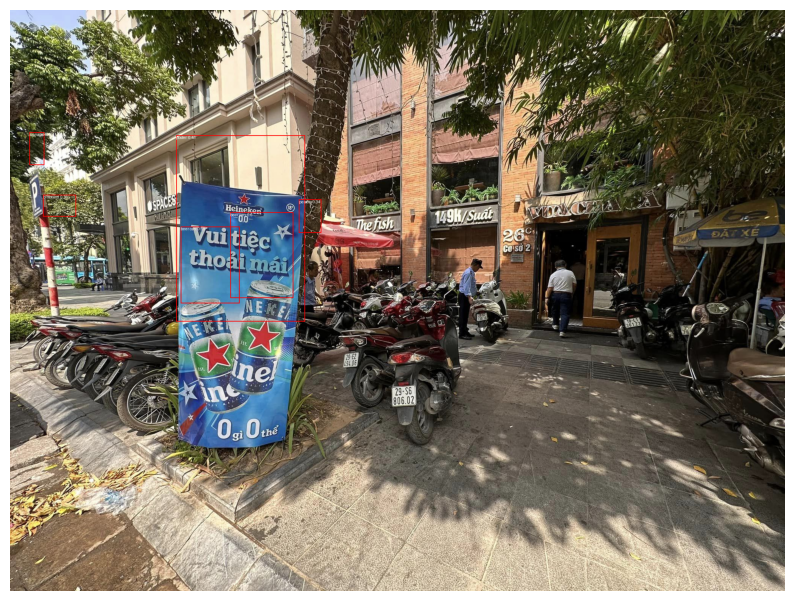

In [3]:
# Read image from the content directory in Colab
url = "./391577614_1574022540001636_4572134634266421212_n.jpg"
im = Image.open(url)

# Define text queries and thresholds
text_queries = [
          "face", "person",
          "beer bottle", "beer can", "beer carton", "beer crate",
          "ice bucket", "ice box", "fridge",
          "signage", "billboard", "poster", "standee",
          "tent card", "display stand", "tabletop",
          "parasol",
          # "drinker", "promotion girl", "seller", "customer"
          ]

# Define thresholds for each class
thresholds = {
    "face":           0.1,
    "person":         0.3,
    "beer bottle":    0.3,
    "beer can":       0.3,
    "beer carton":    0.4,
    "beer crate":     0.4,
    "ice bucket":     0.4,
    "ice box":        0.4,
    "fridge":         0.4,
    "signage":        0.4,
    "billboard":      0.2,
    "poster":         0.3,
    "standee":        0.3,
    "tent card":      0.3,
    "display stand":  0.3,
    "tabletop":       0.3,
    "parasol":        0.3,
    "drinker":        0.2,
    "promotion girl": 0.2,
    "seller":         0.2,
    "customer":       0.1
}

# Process inputs
inputs = processor(text=text_queries, images=im, return_tensors="pt")

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)
    target_sizes = torch.tensor([im.size[::-1]])
    results = processor.post_process_object_detection(outputs, threshold=0.1, target_sizes=target_sizes)[0]

# Extract results
scores = torch.tensor(results["scores"])
labels = torch.tensor(results["labels"])
boxes = torch.tensor(results["boxes"])

# Create a new list to store the final results after NMS
final_boxes = []
final_scores = []
final_labels = []

# Apply NMS separately for each class
unique_labels = labels.unique()
for ul in unique_labels:
    mask = labels == ul
    filtered_boxes = boxes[mask]
    filtered_scores = scores[mask]
    filtered_labels = labels[mask]

    # if filtered_boxes.size(0) == 0:
    #     continue

    nms_indices = nms(filtered_boxes, filtered_scores, iou_threshold=0.2)

    final_boxes.append(filtered_boxes[nms_indices])
    final_scores.append(filtered_scores[nms_indices])
    final_labels.append(filtered_labels[nms_indices])

# Check if final_boxes is not empty before concatenating the results from all classes
if final_boxes:
    final_boxes = torch.cat(final_boxes)
    final_scores = torch.cat(final_scores)
    final_labels = torch.cat(final_labels)
else:
    final_boxes = torch.tensor([])
    final_scores = torch.tensor([])
    final_labels = torch.tensor([])

# Create dataframe
data = {
    "xmin": [],
    "ymin": [],
    "xmax": [],
    "ymax": [],
    "confidence": [],
    "name": []
}

# Draw annotations on the image
draw = ImageDraw.Draw(im)

# Process the results
for box, score, label in zip(final_boxes, final_scores, final_labels):
    label_text = text_queries[label]
    if score.item() >= thresholds[label_text]:
        box = [round(i, 2) for i in box.tolist()]
        data["xmin"].append(box[0])
        data["ymin"].append(box[1])
        data["xmax"].append(box[2])
        data["ymax"].append(box[3])
        data["confidence"].append(round(score.item(), 3))
        data["name"].append(label_text)

        # Draw the bounding box on the image
        draw.rectangle(box, outline="red", width=2)
        draw.text((box[0], box[1]), f"{label_text}: {round(score.item(), 2)}", fill="white")

# Convert data to dataframe
df = pd.DataFrame(data)

# Save dataframe to a CSV file (optional)
df.to_csv('detection_results.csv', index=False)

# Display the dataframe
print(df)

# Show the image with annotations using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(im)
plt.axis('off')
plt.show()